# exp030_1
co-visitation リーク対策版

In [1]:
import os
import sys
import traceback
import gc
import random
import pickle
import pathlib
import subprocess
from dataclasses import dataclass
from dotenv import load_dotenv
load_dotenv
sys.path.append(os.getenv('UTILS_PATH'))
from tqdm import tqdm
import multiprocessing
import inspect

import pandas as pd
import numpy as np
import itertools
import cudf
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import line_notify
import my_logger
from noglobal import noglobal
import optuna

# 設定

In [2]:
@dataclass
class Cfg:
    loglevel = "INFO"
    exp_name = "exp030_1"
    seed = 42
    k = 20
    cand_n = 10
    type2id = {"clicks":0, "carts":1, "orders":2}
    id2type = {0:"clicks", 1:"carts", 2:"orders"}
    train_weeks = ["week3"]
    valid_week = "week4"
    valid_session_n = 100_000
    input_dir = os.getenv('INPUT_DIR')
    output_dir = os.getenv('OUTPUT_DIR')
    prep_dir = os.getenv("PREP_DIR")

cfg = Cfg()
os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name), exist_ok=True)
os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name, "cache"), exist_ok=True)
random.seed(cfg.seed)

logger = my_logger.init_logger(cfg.exp_name)

In [3]:
@noglobal(excepts=["cfg", "logger"])
def evaluate(clicks_labels, carts_labels, orders_labels, 
             clicks_preds, carts_preds, orders_preds, k=20):

    num_clicks = 0
    num_carts = 0
    num_orders = 0
    hit_clicks = 0
    hit_carts = 0
    hit_orders = 0

    for i in range(len(clicks_labels)):
        clicks_label = clicks_labels[i]
        carts_label = carts_labels[i]
        orders_label = orders_labels[i]
        clicks_pred = clicks_preds[i]
        carts_pred = carts_preds[i]
        orders_pred = orders_preds[i]

        if type(clicks_pred) == list:
            clicks_pred = clicks_pred[:k]
        else:
            clicks_pred = []
        if type(carts_pred) == list:
            carts_pred = carts_pred[:k]
        else:
            carts_pred = []    
        if type(orders_pred) == list:
            orders_pred = orders_pred[:k]
        else:
            orders_pred = []

        if not np.isnan(clicks_label):
            num_clicks += 1
            hit_clicks += int(clicks_label in clicks_pred)

        if type(carts_label) == list:
            num_carts += min(len(carts_label), k)
            hit_carts += len(set(carts_pred) & set(carts_label))
            
        if type(orders_label) == list:
            num_orders += min(len(orders_label), k)
            hit_orders += len(set(orders_pred) & set(orders_label))


    recall_clicks = hit_clicks / num_clicks
    recall_carts = hit_carts / num_carts
    recall_orders = hit_orders / num_orders
    w_recall_clicks = recall_clicks * 0.10
    w_recall_carts = recall_carts * 0.30
    w_recall_orders = recall_orders * 0.60
    score = w_recall_clicks + w_recall_carts + w_recall_orders

    results = {}
    results["num_clicks"] = num_clicks
    results["hit_clicks"] = hit_clicks
    results["num_carts"] = num_carts
    results["hit_carts"] = hit_carts
    results["num_orders"] = num_orders
    results["hit_orders"] = hit_orders
    results["recall_clicks"] = format(recall_clicks, ".3f")
    results["recall_carts"] = format(recall_carts, ".3f")
    results["recall_orders"] = format(recall_orders, ".3f")
    results["w_recall_clicks"] = format(w_recall_clicks, ".3f")
    results["w_recall_carts"] = format(w_recall_carts, ".3f")
    results["w_recall_orders"] = format(w_recall_orders, ".3f")
    results["score"] = format(score, ".3f")

    return results

In [4]:
class Candidate:
    @noglobal(excepts=["cfg", "logger"])
    def __init__(self, pdf, labels=None):
        self.df = cudf.from_pandas(pdf)
        self.target_sessions = pdf["session"].unique().tolist()
        self.results = pd.DataFrame(columns=["name", "num_clicks", "hit_clicks", "num_carts", "hit_carts", "num_orders", "hit_orders", 
                                             "recall_clicks", "recall_carts", "recall_orders", "w_recall_clicks", "w_recall_carts", "w_recall_orders", "score"])
        self.output = pd.DataFrame(columns=["session", "aid", "strategy", "rank"], dtype=int)
        self.labels = labels
    
    @noglobal(excepts=["cfg", "logger"])
    def _entry(self, new_candidate_df, name, k):
        logger.info(f"[add_candidate] {name} : start")
        new_candidate_df["strategy"] = name
        new_candidate_df[f"rank"] = new_candidate_df.groupby("session")["session"].cumcount() + 1
        new_candidate_df = new_candidate_df.to_pandas()
        self.output = pd.concat([self.output, new_candidate_df[["session", "aid", "strategy", "rank"]]])

        if self.labels is not None:
            self._eval(new_candidate_df[["session", "aid"]], name, k)
    
    @noglobal(excepts=["cfg", "logger"])
    def _eval(self, new_candidate_df, name, k):
        new_candidate_df = new_candidate_df.groupby("session")["aid"].apply(list).reset_index()
        eval_df = pd.DataFrame(self.target_sessions, columns=["session"])
        eval_df = eval_df.merge(new_candidate_df, on=["session"], how="left")
        assert eval_df["session"].tolist() == self.labels["session"].tolist()
        eval_result = evaluate(self.labels["clicks_labels"].tolist(), self.labels["carts_labels"].tolist(), self.labels["orders_labels"].tolist(),
                               eval_df["aid"].tolist(), eval_df["aid"].tolist(), eval_df["aid"].tolist(), k)
        
        logger.info(str(eval_result))
        self.results = pd.concat([self.results, pd.DataFrame([[name] + list(eval_result.values())], columns=["name"] + list(eval_result.keys()))])

    @noglobal(excepts=["cfg", "logger"])
    def add(self, strategy, name, usetypes=['clicks', 'carts', 'orders'], trans_map=None, k=20):
        logger.info(f"[make_candidate] {name} : start")
        candidate_df = self.df[self.df["type"].isin(usetypes)].copy()
        
        if strategy == "session_frequent":
            candidate_df = self._session_frequent(candidate_df, k)
        elif strategy == "session_latest":
            candidate_df = self._session_latest(candidate_df, k)
        elif strategy == "total_frequent":
            candidate_df = self._total_frequent(candidate_df, k)
        
        if trans_map is not None:
            candidate_df["aid"] = candidate_df["aid"].map(trans_map)
            candidate_df = candidate_df.dropna(subset=["aid"])
            
        self._entry(candidate_df, name, k)

    @noglobal(excepts=["cfg", "logger"])
    def _session_frequent(self, candidate_df, k):
        candidate_df = candidate_df.groupby(["session", "aid"])["ts"].count().reset_index()
        candidate_df.columns = ["session", "aid", "aid_count"]
        candidate_df = candidate_df.sort_values(["session", "aid_count", "aid"], ascending=(True, False, True))
        candidate_df = candidate_df[candidate_df.groupby("session")["aid_count"].cumcount() < k].copy()
        candidate_df = candidate_df[["session", "aid"]].copy()
        return candidate_df

    @noglobal(excepts=["cfg", "logger"])
    def _session_latest(self, candidate_df, k):
        candidate_df = candidate_df.sort_values(["session", "ts"], ascending=(True, False)).drop_duplicates(subset=["session", "aid"])
        candidate_df = candidate_df.sort_values(["session", "ts"], ascending=(True, False))[candidate_df.groupby("session")["ts"].cumcount() < k].copy()
        candidate_df = candidate_df[["session", "aid"]].copy()
        return candidate_df

    @noglobal(excepts=["cfg", "logger"])
    def _total_frequent(self, candidate_df, k):
        candidate_df = candidate_df.groupby("aid")["ts"].count().reset_index()
        candidate_df.columns = ["aid", "aid_count"]
        topk_freq_aids = candidate_df.sort_values("aid_count", ascending=False)["aid"].to_arrow().to_pylist()[:k]
        sessions = []
        aids = []
        for session, aid in itertools.product(self.target_sessions, topk_freq_aids):
            sessions.append(session)
            aids.append(aid)
        candidate_df = cudf.DataFrame({"session": sessions, "aid": aids})
        return candidate_df


In [5]:
@noglobal(excepts=["cfg", "logger"])
def make_cand_df(sessions, labels=None, trans_maps=None):

    if labels is not None:
         cand = Candidate(sessions, labels)
    else:
        cand = Candidate(sessions)

    cand.add(strategy="session_frequent", name="session_frequent", k=cfg.cand_n)
    cand.add(strategy="session_latest", name="session_latest", k=cfg.cand_n)
    # cand.add(strategy="total_frequent", name="total_frequent", k=cfg.cand_n)
    cand.add(strategy="session_frequent", trans_map=trans_maps["pair0"], name="session_frequent_pair", k=cfg.cand_n)
    
    for i in range(10):
        cand.add(strategy="session_latest", trans_map=trans_maps[f"pair{str(i)}"], name=f"session_latest_pair{str(i)}", k=cfg.cand_n)
    
    for i in range(10):
        cand.add(strategy="session_latest", trans_map=trans_maps[f"time_wt_pair{str(i)}"], name=f"session_latest_time_wt_pair{str(i)}", k=cfg.cand_n)
    
    cand.add(strategy="session_latest", trans_map=trans_maps["type_wt_pair"], name="session_latest_type_wt_pair", k=cfg.cand_n)
    cand.add(strategy="session_latest", trans_map=trans_maps["clicks2carts_pair"], name="session_latest_clicks2carts_pair", k=cfg.cand_n)
    cand.add(strategy="session_latest", trans_map=trans_maps["clicks2orders_pair"], name="session_latest_clicks2orders_pair", k=cfg.cand_n)
    if labels is not None:
        return cand.output, cand.results
    else:
        return cand.output

In [6]:
@noglobal(excepts=["cfg", "logger"])
def get_trans_maps():
    """
    aidを別のaidに置き換えるmapping辞書を取得する
    """
    trans_maps = {}

    pair_df_org = pd.read_pickle(cfg.prep_dir + "co_visitation_matrix_v5_week4.pkl")
    pair_df_org = pair_df_org[pair_df_org["cnt"] > 3].copy()
    pair_df_org = pair_df_org.sort_values(["aid_x", "cnt"], ascending=(True, False))
    for i in range(10):
        pair_df = pair_df_org.groupby("aid_x").nth(i).reset_index()[["aid_x", "aid_y"]]
        pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
        trans_maps[f"pair{str(i)}"] = pair_dict

    pair_df = pd.read_pickle(cfg.prep_dir + "co_visitation_matrix_clicks_week4.pkl")
    pair_df = pair_df[pair_df["cnt"] > 3].copy()
    pair_df = pair_df.sort_values(["aid_x", "cnt"], ascending=(True, False))
    pair_df = pair_df.groupby("aid_x").head(1)[["aid_x", "aid_y"]]
    pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
    trans_maps["clicks_pair"] = pair_dict

    pair_df = pd.read_pickle(cfg.prep_dir + "co_visitation_matrix_carts_week4.pkl")
    pair_df = pair_df[pair_df["cnt"] > 3].copy()
    pair_df = pair_df.sort_values(["aid_x", "cnt"], ascending=(True, False))
    pair_df = pair_df.groupby("aid_x").head(1)[["aid_x", "aid_y"]]
    pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
    trans_maps["carts_pair"] = pair_dict

    pair_df = pd.read_pickle(cfg.prep_dir + "co_visitation_matrix_orders_week4.pkl")
    pair_df = pair_df[pair_df["cnt"] > 3].copy()
    pair_df = pair_df.sort_values(["aid_x", "cnt"], ascending=(True, False))
    pair_df = pair_df.groupby("aid_x").head(1)[["aid_x", "aid_y"]]
    pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
    trans_maps["orders_pair"] = pair_dict

    pair_df_org = pd.read_pickle(cfg.prep_dir + "co_visitation_matrix_time_weighted_v2_week4.pkl")
    pair_df_org = pair_df_org.sort_values(["aid_x", "wt"], ascending=(True, False))
    for i in range(10):
        pair_df = pair_df_org.groupby("aid_x").nth(i).reset_index()[["aid_x", "aid_y"]]
        pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
        trans_maps[f"time_wt_pair{str(i)}"] = pair_dict

    pair_df = pd.read_pickle(cfg.prep_dir + "co_visitation_matrix_type_weighted_week4.pkl")
    pair_df = pair_df.sort_values(["aid_x", "wt"], ascending=(True, False))
    pair_df = pair_df.groupby("aid_x").head(1)[["aid_x", "aid_y"]]
    pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
    trans_maps["type_wt_pair"] = pair_dict

    pair_df = pd.read_pickle(cfg.prep_dir + "co_visitation_matrix_clicks2carts_week4.pkl")
    pair_df = pair_df.sort_values(["aid_x", "cnt"], ascending=(True, False))
    pair_df = pair_df.groupby("aid_x").head(1)[["aid_x", "aid_y"]]
    pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
    trans_maps["clicks2carts_pair"] = pair_dict

    pair_df = pd.read_pickle(cfg.prep_dir + "co_visitation_matrix_clicks2orders_week4.pkl")
    pair_df = pair_df.sort_values(["aid_x", "cnt"], ascending=(True, False))
    pair_df = pair_df.groupby("aid_x").head(1)[["aid_x", "aid_y"]]
    pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
    trans_maps["clicks2orders_pair"] = pair_dict

    return trans_maps


In [7]:
class Cache:
    @noglobal(excepts=["cfg", "logger"])
    def __init__(self):
        self.cache_dir = (os.path.join(cfg.output_dir, cfg.exp_name, "cache"))
        self.cache_dir_path = pathlib.Path(self.cache_dir)
        self.caches = list(self.cache_dir_path.glob("*.pkl"))

    @noglobal(excepts=["cfg", "logger"])
    def get_abspath(self, filename):
        return (os.path.join(self.cache_dir, f"{cfg.exp_name}_{filename}"))
    
    @noglobal(excepts=["cfg", "logger"])
    def exists(self, path):
        return len([str(c) for c in self.caches if path == str(c)]) > 0

In [8]:
@noglobal(excepts=["cfg", "logger"])
def make_valid_data(trans_maps):
    valid_week = cfg.valid_week
    dfs = []
    
    logger.info(f"[make_valid] valid_week : {valid_week}")
    # データ読み込み
    logger.info("[make_valid] read_data : start")
    week_sessions = pd.read_pickle(os.getenv("PREP_DIR") + f"train_sessions_{valid_week}.pkl")
    week_labels = pd.read_pickle(os.getenv("PREP_DIR") + f"labels_{valid_week}.pkl")
    valid_session_ids = week_sessions["session"].unique().tolist()
    logger.info("[make_valid] read_data : end")

    # validに使うsessionを絞る (trainに存在するsessionを除外した上で設定した数に絞る)
    logger.info("[make_valid] valid_session_extract : start")
    valid_session_n = min(cfg.valid_session_n, len(valid_session_ids))
    valid_session_ids = random.sample(valid_session_ids, valid_session_n)
    week_sessions = week_sessions[week_sessions["session"].isin(valid_session_ids)].copy()
    week_labels = week_labels[week_labels["session"].isin(valid_session_ids)].copy()
    logger.info("[make_valid] valid_session_extract : end")

    # 候補選出
    logger.info("[make_valid] make_cand_df : start")
    valid, results = make_cand_df(week_sessions, labels=week_labels, trans_maps=trans_maps)

    return valid, week_labels, results

In [9]:
@noglobal(excepts=["cfg", "logger"])
def make_test_data(trans_maps):
    # testデータ作成
    test_sessions = pd.read_pickle(cfg.prep_dir + f"test_sessions.pkl")

    dfs =[]
    # 候補選出
    logger.info("[make_test] make_cand_df")
    test = make_cand_df(test_sessions, trans_maps=trans_maps)
    return test

In [10]:
logger.info(f"START")
line_notify.send(f"{cfg.exp_name} | START")

cache = Cache()

logger.info(f"-------- get_trans_maps --------")
cache_path = cache.get_abspath("trans_maps.pkl")
if cache.exists(cache_path):
    logger.info("cache exists. load cache and skip process.")
    with open(cache_path, "rb") as f:
        trans_maps = pickle.load(f)
else:
    trans_maps = get_trans_maps()
    with open(cache_path, "wb") as f:
        pickle.dump(trans_maps, f)

valid, valid_labels, results = make_valid_data(trans_maps)

0:00:00.401548 	 START
0:00:06.403811 	 -------- get_trans_maps --------
0:01:16.026316 	 [make_valid] valid_week : week4
0:01:16.027638 	 [make_valid] read_data : start
0:01:22.442769 	 [make_valid] read_data : end
0:01:22.444066 	 [make_valid] valid_session_extract : start
0:01:23.424879 	 [make_valid] valid_session_extract : end
0:01:23.426028 	 [make_valid] make_cand_df : start
0:01:23.488438 	 [make_candidate] session_frequent : start
0:01:23.802300 	 [add_candidate] session_frequent : start
0:01:25.435557 	 {'num_clicks': 97136, 'hit_clicks': 29086, 'num_carts': 41843, 'hit_carts': 10282, 'num_orders': 19599, 'hit_orders': 9741, 'recall_clicks': '0.299', 'recall_carts': '0.246', 'recall_orders': '0.497', 'w_recall_clicks': '0.030', 'w_recall_carts': '0.074', 'w_recall_orders': '0.298', 'score': '0.402'}
0:01:25.446444 	 [make_candidate] session_latest : start
0:01:25.748784 	 [add_candidate] session_latest : start
0:01:27.330366 	 {'num_clicks': 97136, 'hit_clicks': 29497, 'num_c

In [11]:
results

,name,num_clicks,hit_clicks,num_carts,hit_carts,num_orders,hit_orders,recall_clicks,recall_carts,recall_orders,w_recall_clicks,w_recall_carts,w_recall_orders,score
0,session_frequent,97136,29086,41843,10282,19599,9741,0.299,0.246,0.497,0.030,0.074,0.298,0.402
0,session_latest,97136,29497,41843,10523,19599,9242,0.304,0.251,0.472,0.030,0.075,0.283,0.389
0,session_frequent_pair,97136,7074,41843,2472,19599,1959,0.073,0.059,0.100,0.007,0.018,0.060,0.085
0,session_latest_pair0,97136,7211,41843,2529,19599,1916,0.074,0.060,0.098,0.007,0.018,0.059,0.084
0,session_latest_pair1,97136,5201,41843,1920,19599,1422,0.054,0.046,0.073,0.005,0.014,0.044,0.063
0,session_latest_pair2,97136,3898,41843,1597,19599,1148,0.040,0.038,0.059,0.004,0.011,0.035,0.051
0,session_latest_pair3,97136,3353,41843,1331,19599,1032,0.035,0.032,0.053,0.003,0.010,0.032,0.045
0,session_latest_pair4,97136,2903,41843,1193,19599,931,0.030,0.029,0.048,0.003,0.009,0.029,0.040
0,session_latest_pair5,97136,2639,41843,1021,19599,816,0.027,0.024,0.042,0.003,0.007,0.025,0.035
0,session_latest_pair6,97136,2350,41843,1000,19599,734,0.024,0.024,0.037,0.002,0.007,0.022,0.032


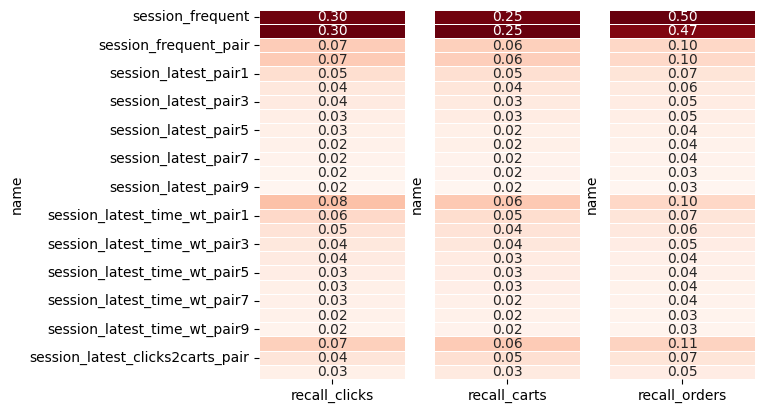

In [12]:
fig, axs = plt.subplots(1, 3)
sns.heatmap(results.set_index("name")[["recall_clicks"]].astype(float),
            annot=True, linewidths=.5, fmt="1.2f", cmap="Reds", cbar=False, ax=axs[0])
sns.heatmap(results.set_index("name")[["recall_carts"]].astype(float),
            annot=True, linewidths=.5, fmt="1.2f", cmap="Reds", cbar=False, ax=axs[1], yticklabels=False)
sns.heatmap(results.set_index("name")[["recall_orders"]].astype(float),
            annot=True, linewidths=.5, fmt="1.2f", cmap="Reds", cbar=False, ax=axs[2], yticklabels=False)
plt.savefig(cfg.output_dir + f'{cfg.exp_name}/candidate_strategy_recalls.png')

In [13]:
# 予測値を全て使えたときのrecall
valid_all = valid.drop_duplicates(subset= ["session", "aid"])
session_cnt_max = valid_all["session"].value_counts().max()
valid_all = valid_all.groupby("session")["aid"].apply(list).reset_index()

all_results = evaluate(valid_labels["clicks_labels"].tolist(),
                       valid_labels["carts_labels"].tolist(),
                       valid_labels["orders_labels"].tolist(),
                       valid_all["aid"].tolist(),
                       valid_all["aid"].tolist(),
                       valid_all["aid"].tolist(),
                       session_cnt_max)
logger.info("session_cnt_max")
logger.info(session_cnt_max)
logger.info("all_pred_results")
logger.info(all_results)

0:02:22.846848 	 session_cnt_max
0:02:22.848212 	 213
0:02:22.849357 	 all_pred_results
0:02:22.850061 	 {'num_clicks': 97136, 'hit_clicks': 49513, 'num_carts': 43611, 'hit_carts': 16484, 'num_orders': 20109, 'hit_orders': 11968, 'recall_clicks': '0.510', 'recall_carts': '0.378', 'recall_orders': '0.595', 'w_recall_clicks': '0.051', 'w_recall_carts': '0.113', 'w_recall_orders': '0.357', 'score': '0.521'}


In [14]:
raise ValueError

ValueError: 

In [ ]:
def objective_type_recall(df, labels, type_):
    def objective(trial):
        trial_df = df.copy()
        session_frequent = trial.suggest_float("session_frequent", 0, 1)
        session_latest = trial.suggest_float("session_latest", 0, 1)
        session_frequent_pair = trial.suggest_float("session_frequent_pair", 0, 1)
        session_latest_pair0 = trial.suggest_float("session_latest_pair0", 0, 1)
        session_latest_pair1 = trial.suggest_float("session_latest_pair1", 0, 1)
        session_latest_pair2 = trial.suggest_float("session_latest_pair2", 0, 1)
        session_latest_pair3 = trial.suggest_float("session_latest_pair3", 0, 1)
        session_latest_pair4 = trial.suggest_float("session_latest_pair4", 0, 1)
        session_latest_pair5 = trial.suggest_float("session_latest_pair5", 0, 1)
        session_latest_pair6 = trial.suggest_float("session_latest_pair6", 0, 1)
        session_latest_pair7 = trial.suggest_float("session_latest_pair7", 0, 1)
        session_latest_pair8 = trial.suggest_float("session_latest_pair8", 0, 1)
        session_latest_pair9 = trial.suggest_float("session_latest_pair9", 0, 1)

        session_latest_time_wt_pair0 = trial.suggest_float("session_latest_time_wt_pair0", 0, 1)
        session_latest_time_wt_pair1 = trial.suggest_float("session_latest_time_wt_pair1", 0, 1)
        session_latest_time_wt_pair2 = trial.suggest_float("session_latest_time_wt_pair2", 0, 1)
        session_latest_time_wt_pair3 = trial.suggest_float("session_latest_time_wt_pair3", 0, 1)
        session_latest_time_wt_pair4 = trial.suggest_float("session_latest_time_wt_pair4", 0, 1)
        session_latest_time_wt_pair5 = trial.suggest_float("session_latest_time_wt_pair5", 0, 1)
        session_latest_time_wt_pair6 = trial.suggest_float("session_latest_time_wt_pair6", 0, 1)
        session_latest_time_wt_pair7 = trial.suggest_float("session_latest_time_wt_pair7", 0, 1)
        session_latest_time_wt_pair8 = trial.suggest_float("session_latest_time_wt_pair8", 0, 1)
        session_latest_time_wt_pair9 = trial.suggest_float("session_latest_time_wt_pair9", 0, 1)
        
        session_latest_time_wt_pair = trial.suggest_float("session_latest_time_wt_pair", 0, 1)
        session_latest_type_wt_pair = trial.suggest_float("session_latest_type_wt_pair", 0, 1)
        session_latest_clicks2carts_pair = trial.suggest_float("session_latest_clicks2carts_pair", 0, 1)
        session_latest_clicks2orders_pair = trial.suggest_float("session_latest_clicks2orders_pair", 0, 1)
        
        wt_dict = {
            'session_frequent': session_frequent,
            'session_latest': session_latest, 
            'session_frequent_pair': session_frequent_pair, 
            'session_latest_pair0': session_latest_pair0,
            'session_latest_pair1': session_latest_pair1, 
            'session_latest_pair2': session_latest_pair2,
            'session_latest_pair3': session_latest_pair3, 
            'session_latest_pair4': session_latest_pair4,
            'session_latest_pair5': session_latest_pair5,
            'session_latest_pair6': session_latest_pair6,
            'session_latest_pair7': session_latest_pair7,
            'session_latest_pair8': session_latest_pair8,
            'session_latest_pair9': session_latest_pair9,
            'session_latest_time_wt_pair0': session_latest_time_wt_pair0,
            'session_latest_time_wt_pair1': session_latest_time_wt_pair1, 
            'session_latest_time_wt_pair2': session_latest_time_wt_pair2,
            'session_latest_time_wt_pair3': session_latest_time_wt_pair3, 
            'session_latest_time_wt_pair4': session_latest_time_wt_pair4,
            'session_latest_time_wt_pair5': session_latest_time_wt_pair5,
            'session_latest_time_wt_pair6': session_latest_time_wt_pair6,
            'session_latest_time_wt_pair7': session_latest_time_wt_pair7,
            'session_latest_time_wt_pair8': session_latest_time_wt_pair8,
            'session_latest_time_wt_pair9': session_latest_time_wt_pair9,
            'session_latest_time_wt_time_wt_pair': session_latest_time_wt_pair,
            'session_latest_time_wt_type_wt_pair': session_latest_type_wt_pair,
            'session_latest_clicks2carts_pair': session_latest_clicks2carts_pair,
            'session_latest_clicks2orders_pair': session_latest_clicks2orders_pair,
        }

        trial_df["rank"] = trial_df["rank"] * trial_df["strategy"].map(wt_dict)
        trial_df = trial_df.sort_values(["session", "rank"])
        trial_df = trial_df.drop_duplicates(subset= ["session", "aid"], keep="first")
        trial_df = trial_df.groupby(["session"]).head(20)
        trial_df = trial_df.groupby("session")["aid"].apply(list).reset_index()

        result = evaluate(labels["clicks_labels"].tolist(),
                          labels["carts_labels"].tolist(),
                          labels["orders_labels"].tolist(),
                          trial_df["aid"].tolist(),
                          trial_df["aid"].tolist(),
                          trial_df["aid"].tolist(),
                          cfg.k)

        return float(result[f"recall_{type_}"])
    return objective



In [ ]:
n_trials = 100

# パラメータチューニング

In [ ]:
wt = {}
recall = {}

for type_ in ["clicks", "carts", "orders"]:
    logger.info(type_)
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_type_recall(valid, valid_labels, type_), n_trials=n_trials)
    wt[type_] = study.best_params
    recall[type_] = study.best_value
    logger.info(f"{type_}_recall_best_weights : {str(study.best_params)}")
    logger.info(f"{type_}_recall_best_value : {study.best_value}")

score = (recall["clicks"] * 0.1) + (recall["carts"] * 0.3) + (recall["orders"] * 0.6)
logger.info(f"SCORE : {score}")

0:02:18.225416 	 clicks
[I 2022-12-07 01:43:39,183] A new study created in memory with name: no-name-60dd3b89-961d-41ca-9c3e-d7bd15cdabd5
[I 2022-12-07 01:43:44,759] Trial 0 finished with value: 0.446 and parameters: {'session_frequent': 0.7175572238957875, 'session_latest': 0.30470957773967877, 'session_frequent_pair': 0.612588099406637, 'session_latest_pair0': 0.6450374296811144, 'session_latest_pair1': 0.6872861278118704, 'session_latest_pair2': 0.9277449804835949, 'session_latest_pair3': 0.09508048867287255, 'session_latest_pair4': 0.3967959350366074, 'session_latest_pair5': 0.309692955962262, 'session_latest_pair6': 0.3011300642670671, 'session_latest_pair7': 0.3899952187822827, 'session_latest_pair8': 0.08874014433729094, 'session_latest_pair9': 0.13766152897434558, 'session_latest_time_wt_pair0': 0.9597703490343167, 'session_latest_time_wt_pair1': 0.06219466277225516, 'session_latest_time_wt_pair2': 0.8722789658945269, 'session_latest_time_wt_pair3': 0.8022377117253073, 'session

# sub作成

In [ ]:
test = make_test_data(trans_maps)
sub = pd.read_csv(cfg.input_dir + f"sample_submission.csv", usecols=["session_type"])
dfs = []

for type_ in ["clicks", "carts", "orders"]:
    test_type = test.copy()
    test_type["rank"] 
    test_type["rank"] = test_type["rank"] * test_type["strategy"].map(wt[type_])
    test_type = test_type.sort_values(["session", "rank"])
    test_type = test_type.drop_duplicates(subset= ["session", "aid"], keep="first")
    test_type = test_type.groupby(["session"]).head(20)
    test_type["aid"] = test_type["aid"].astype(str)
    test_type = test_type.groupby("session")["aid"].apply(list).reset_index()
    test_type["aid"] = test_type["aid"].apply(lambda x: ' '.join(x))
    test_type["session_type"] = test_type["session"].astype(str) + f"_{type_}"
    test_type =test_type.rename(columns={"aid": "labels"})
    dfs.append(test_type)
test_preds = pd.concat(dfs)

sub = sub.merge(test_preds, on="session_type", how="left")
sub[["session_type", "labels"]].to_csv(cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_sub.csv", index=False)

0:29:22.762408 	 [make_test] make_cand_df
0:29:23.139073 	 [make_candidate] session_frequent : start
0:29:23.668382 	 [add_candidate] session_frequent : start
0:29:24.022727 	 [make_candidate] session_latest : start
0:29:24.339656 	 [add_candidate] session_latest : start
0:29:24.746067 	 [make_candidate] session_frequent_pair : start
0:29:25.273066 	 [add_candidate] session_frequent_pair : start
0:29:25.741896 	 [make_candidate] session_latest_pair0 : start
0:29:26.291206 	 [add_candidate] session_latest_pair0 : start
0:29:26.792678 	 [make_candidate] session_latest_pair1 : start
0:29:27.356534 	 [add_candidate] session_latest_pair1 : start
0:29:27.911163 	 [make_candidate] session_latest_pair2 : start
0:29:28.484378 	 [add_candidate] session_latest_pair2 : start
0:29:29.039453 	 [make_candidate] session_latest_pair3 : start
0:29:29.605923 	 [add_candidate] session_latest_pair3 : start
0:29:30.265695 	 [make_candidate] session_latest_pair4 : start
0:29:30.850944 	 [add_candidate] sessi

In [ ]:
sub.head()

,session_type,session,labels
0,12899779_clicks,12899779,59625 448688 941596 731692 1253524 1854910 438...
1,12899779_carts,12899779,59625 1130911 1854910 894169 1790770 737445 43...
2,12899779_orders,12899779,59625 941596 1854910 737445 523135 731692 8941...
3,12899780_clicks,12899780,1142000 1360606 1383529 889686 736515 409620 4...
4,12899780_carts,12899780,1142000 582732 736515 973453 1502122 636101 17...
